In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[0].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       


# ipysh.Bootstrap_support.debug()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


Using TensorFlow backend.


# TEST QSH


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15_clean.npy'
try: qsh.load(file)
except: raise FileNotFoundError
    
qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F'])  ## use this for Br_rm
# qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm']) 

# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive(['te'])
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive(['te'])


print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [3]:
# Bt_min, Bt_max = np.nanmin(qsh['Bt_rm']), np.nanmax(qsh['Bt_rm'])
Br_min, Br_max = np.nanmin(qsh['Br_rm']), np.nanmax(qsh['Br_rm'])

def _map(xy,p,Br):
    # Bt = (Bt-Bt_min)/(Bt_max-Bt_min)
    Br = (Br-Br_min)/(Br_max-Br_min)
    pBr = tf.concat([p,Br], axis=0)
    # return (xy,pBtBr),(xy,pBtBr)
    return pBr,xy

# ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm']).map(lambda x,y,br: _map(x,y,br) )
ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','Br_rm']).map(lambda x,y,br: _map(x,y,br) )
# [x for x in ds.shuffle(100).batch(1).take(1)][0]

W0902 14:13:20.125850 139887727306560 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:504: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [172]:
vae = models.AEFIT5.AEFIT5(latent_dim=24, feature_dim=30, dprate=0.1, scale=1, geometry=[80,80,80,40])
vae.inference_net.trainable = False
gen = vae.generative_net



AEFIT5 a ready:


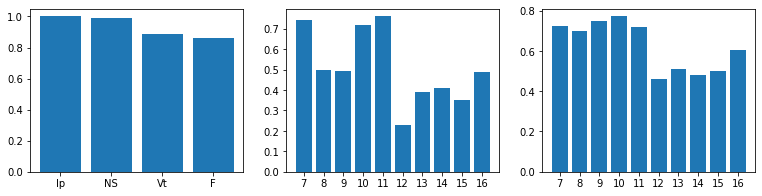

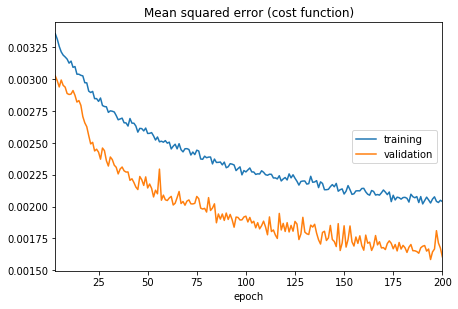

Mean squared error (cost function):
training   (min:    0.002, max:    0.004, cur:    0.002)
validation (min:    0.002, max:    0.003, cur:    0.002)
100/100 [==============================] - 14s 143ms/step - loss: 0.0020 - val_loss: 0.0016


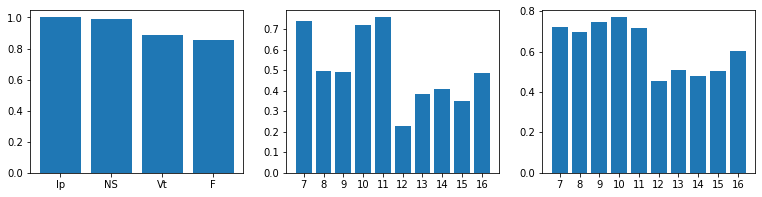

In [174]:
# TRAIN MODEL
rel = gen.layers[0]
rel.rate = 0.3
# l1_l2 = tf.keras.regularizers.l1_l2
# for l in gen.layers:
#     if issubclass(type(l), tf.keras.layers.Dense):
#         l.activity_regularizer = l1_l2(0.01)

gen.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )
print(rel.weights)        
    
# qsh.shuffle()
history = gen.fit( ds.skip(3000).batch(100).take(100), validation_data=ds.take(3000).batch(100).take(100), epochs=200,
                  callbacks=[PlotLossesCallback(), PlotRelevanceCallback()] )

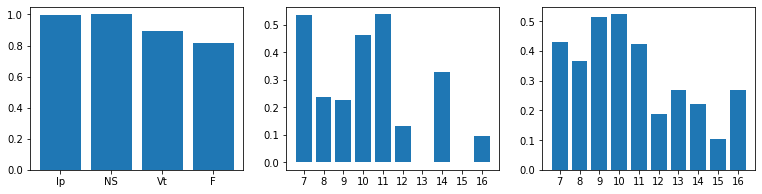

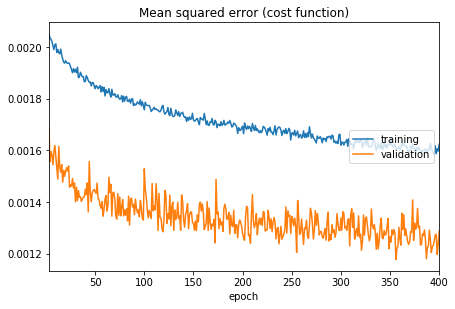

Mean squared error (cost function):
training   (min:    0.002, max:    0.002, cur:    0.002)
validation (min:    0.001, max:    0.002, cur:    0.001)
446/446 [==============================] - 56s 125ms/step - loss: 0.0016 - val_loss: 0.0013


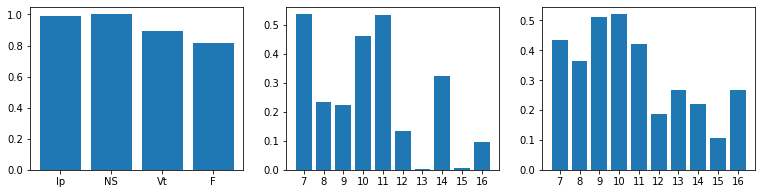

In [260]:
history1 = gen.fit( ds.skip(3000).batch(100), validation_data=ds.take(3000).batch(100).take(100), epochs=400,
                  callbacks=[PlotLossesCallback(), PlotRelevanceCallback()] )

In [ ]:
gen.layers[0].weights

In [ ]:
index = qsh[0].n
w = gen.layers[0].weights
%matplotlib inline

def plot_bar_x(index, w, title):
    # this is for plotting purpose
    plt.figure(title)
    plt.bar(index, w)
    plt.xlabel('n', fontsize=5)
    plt.ylabel('SXR relevance', fontsize=10)
    plt.xticks(index, fontsize=10, rotation=30)
    plt.title(title)
    plt.show()

re,im = w[0][4:14], w[0][14:24]
plot_bar_x(index, re, 're(Br)')
plot_bar_x(index, im, 'im(Br)')


In [351]:
vae.save('step12_gan_PBr_reim')
# vae.load('step12_gan_PBr_reim')

In [261]:
pos = 0

88


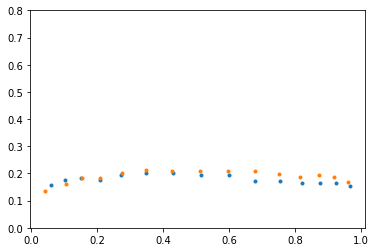

In [350]:
print(pos)
d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]

def plot(xy):
    plt.figure('plot')
    ax = plt.gca()
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,'.')

xy = d_pos[1]
XY = gen(d_pos[0], training=False)
# XY = tf.sigmoid(XY)
plot(xy)
plot(XY)
pos += 1

# ADD ALSO BT

In [ ]:
Bt_min, Bt_max = np.nanmin(qsh['Bt_rm']), np.nanmax(qsh['Bt_rm'])
Br_min, Br_max = np.nanmin(qsh['Br_rm']), np.nanmax(qsh['Br_rm'])

def _map(xy,p,Br,Bt):
    Bt = (Bt-Bt_min)/(Bt_max-Bt_min)
    Br = (Br-Br_min)/(Br_max-Br_min)
    pBrBt = tf.concat([p,Br,Bt], axis=0)
    # return (xy,pBtBr),(xy,pBtBr)
    return pBrBt,xy

# ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm']).map(lambda x,y,br: _map(x,y,br) )
ds2 = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','Br_rm','Bt_rm']).map(lambda x,y,br,bt: _map(x,y,br,bt) )
# [x for x in ds.shuffle(100).batch(1).take(1)][0]

In [ ]:
vae2 = models.AEFIT5.AEFIT5(latent_dim=44, feature_dim=30, dprate=0., scale=1, geometry=[1,60,60,60,40])
vae2.inference_net.trainable = False
gen2 = vae2.generative_net

In [ ]:
gen2.compile( vae2.optimizer, vae2.loss )
history = gen2.fit( ds2.skip(2600).batch(100).take(40), validation_data=ds2.take(2600).batch(100), epochs=200, 
                   callbacks=[PlotLossesCallback(), PlotRelevanceCallback()] )

In [ ]:
#vae2.save('step12_gen2')

In [ ]:
pos=0

In [ ]:
print(pos)
d_pos = [x for x in ds2.skip(pos).batch(1).take(1)][0]

def plot(xy):
    plt.figure('plot')
    ax = plt.gca()
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,'.')

xy = d_pos[1]
XY = gen2(d_pos[0], training=False)
XY = tf.sigmoid(XY)
plot(xy)
plot(XY)
pos += 1

In [ ]:
index = qsh[0].n
w = gen2.layers[0].weights
print(w)

def plot_bar_x(index, w, title):
    # this is for plotting purpose
    plt.figure(title)
    plt.bar(index, w)
    plt.xlabel('n', fontsize=5)
    plt.ylabel('SXR relevance', fontsize=10)
    plt.xticks(index, fontsize=10, rotation=30)
    plt.title(title)
    plt.show()

re,im = w[0][4:14], w[0][14:24]
plot_bar_x(index, re, 're(Br)')
plot_bar_x(index, im, 'im(Br)')
